┌ Warning: This version of CUDA.jl only supports NVIDIA drivers for CUDA 10.1 or higher (yours is for CUDA 9.1.0)
└ @ CUDA C:\Users\Fluid3\.julia\packages\CUDA\M4jkK\src\initialization.jl:100


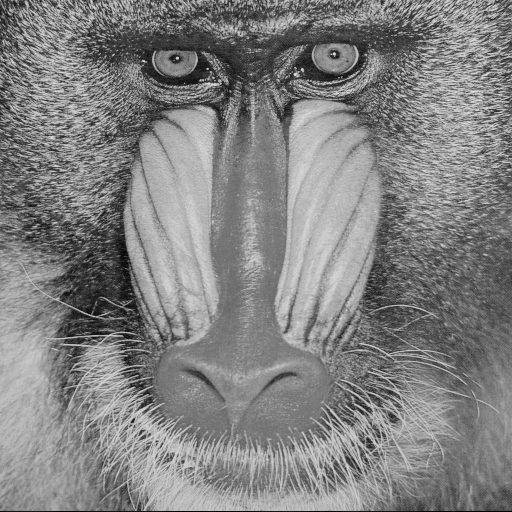

In [1]:
using Flux
import TestImages: testimage
import ImageView: imshow
import Images: Gray
img = testimage("mandrill")
im0 = 1*Gray.(img)

In [2]:
m_im0 = convert(Matrix{Float32}, im0)

function warp3(x, y, p) # 0:31
    knob = p[:knob]
    clip(n, nsize) = max(min(nsize, n), 1)
    (xnew, ynew) =
        # clip(convert(Int, floor(x - 10 * (knob / 32) * sin(y/4))), xsize), y), # currently unused variant
        # clip(convert(Int, floor(x + 10 * ((knob - 16) / 16) * sin(y/4))), xsize), y) # normalize to get +/-
        (clip(x + 10 * ((knob - 16) / 16) * sin(y/4), p[:xsize]), y)
    xnew, ynew
end

warp3 (generic function with 1 method)

In [3]:
function apply_warp(warp, im, p)
    (xsize, ysize) = size(im)
    p[:xsize] = xsize
    p[:ysize] = ysize
    function linear_interpolation(x_y)
        # a rough draft, this can be improved; works on im
        x = x_y[1]
        y = x_y[2]
        dx=mod(x,1)
        dy=mod(y,1)
        x_left = floor(Int,x)
        y_left = floor(Int,y)
        x_right = min(x_left + 1, xsize)
        y_right = min(y_left + 1, ysize)
        im[x_left,y_left]*(1-dx)*(1-dy) + im[x_left,y_right]*(1-dx)*dy + im[x_right,y_left]*dx*(1-dy) + im[x_right, y_right]*dx*dy
    end
    [linear_interpolation(warp(x,y,p)) for x in 1:xsize, y in 1:ysize]
end

apply_warp (generic function with 1 method)

In [4]:
pars = Dict(:knob=>0, :dummy=>0.0)
# at least one of the above should be float and not integer, so that the dictionary type is
# Dict{Symbol, Real}  and not Dict{Symbol, Int64}

Dict{Symbol, Real} with 2 entries:
  :dummy => 0.0
  :knob  => 0

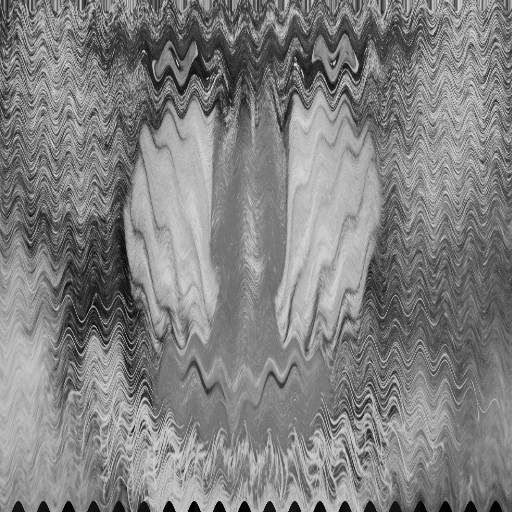

In [5]:
m_im0_warped = apply_warp(warp3, m_im0, pars)
Gray.(m_im0_warped)

In [6]:
# scale image so that all points brightness are between 0 and 1, and that full range is used
# we are going to use this on plain matrices and not on images, so this code changed at second-refactor
function normalize_image(im)
    im_res = im .- minimum(im)
    return (1/maximum(im_res))*im_res
end

normalize_image (generic function with 1 method)

In [7]:
import LinearAlgebra: transpose

In [8]:
norm_columns(f, x) = f.(x) ./ (sum(f.(x), dims=1))

norm_columns (generic function with 1 method)

In [10]:
# this version returns an ordinary matrix, does not try to produce an image
# this is introduced in second-refactor
norm_image_columns(f, x) = normalize_image(norm_columns(f, x))

norm_image_columns (generic function with 1 method)

In [11]:
transposed_product(x) = normalize_image(transpose(x)*x)

transposed_product (generic function with 1 method)

In [12]:
value3(A) = transposed_product(norm_image_columns(x -> x+1, A))

value3 (generic function with 1 method)

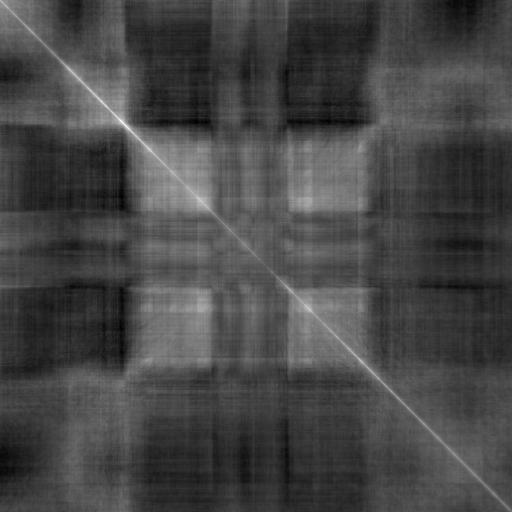

In [13]:
p_m_im0_norm = value3(m_im0)
Gray.(p_m_im0_norm)

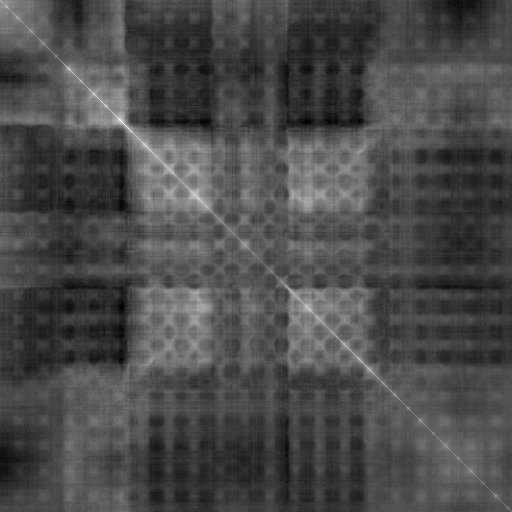

In [14]:
p_m_im0_warped_norm = value3(m_im0_warped)
Gray.(p_m_im0_warped_norm)

In [22]:
import LinearAlgebra: norm
loss(x, y) = norm(value3(x) - y)

loss (generic function with 1 method)

In [23]:
import Flux.Optimise: update!

In [25]:
function steps!(x, y, loss, opt, accum, n_steps = 1)
    for i = 1:n_steps
        p = params(x)
        push!(accum, deepcopy(x)) # I am unhappy about the loss of intermediate parameter values
        grads = gradient(()->loss(x, y), p)
        update!(opt, p, grads)
        println(loss(x, y))
    end
    loss(x, y)
end

steps! (generic function with 2 methods)

In [18]:
m_im0_warped_copy = deepcopy(m_im0_warped)

512×512 Matrix{Float64}:
 0.568627  0.219608  0.192157  0.34902   …  0.443137  0.6       0.694118
 0.568627  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.568627  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.508812  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.374461  0.219608  0.192157  0.34902      0.443137  0.6       0.694118
 0.289585  0.255916  0.192157  0.34902   …  0.443137  0.6       0.694118
 0.311433  0.406567  0.192157  0.34902      0.443137  0.6       0.694118
 0.330864  0.464809  0.185676  0.34902      0.443137  0.6       0.694118
 0.241128  0.522038  0.161183  0.34902      0.443137  0.6       0.533097
 0.148002  0.441317  0.215675  0.298524     0.443137  0.595302  0.353947
 0.178914  0.277868  0.399191  0.214545  …  0.466496  0.512663  0.283585
 0.18434   0.2       0.537088  0.184983     0.468583  0.329828  0.324055
 0.138707  0.197579  0.605528  0.192826     0.355058  0.299991  0.634525
 ⋮                        

In [19]:
matrices = []

Any[]

In [20]:
opt = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [26]:
loss(m_im0, p_m_im0_warped_norm)

20.39865222030749

In [27]:
loss(m_im0_warped, p_m_im0_norm)

20.39865222030749

In [45]:
steps!(m_im0_warped, p_m_im0_norm, loss, opt, matrices, 60)

3.9560086894606044
3.9141765641612225
3.8726432502537556
3.8314099976241796
3.7904780293582223
3.7498489430444444
3.709525687313059
3.6695172545219483
3.629856929908643
3.5906885358686083
3.5526574729667453
3.5187254177489695
3.498305374098979
3.490492924879898
3.4266731207858334
3.3626771874204784
3.3596168780615496
3.3011431847513024
3.2588598448888377
3.2426919359903885
3.1815602007216066
3.1619633226807293
3.1224265272603438
3.078539516288067
3.0587264302327477
3.009286732000011
2.9836834010487965
2.949741478850927
2.908988904611974
2.8861059913030473
2.8451216628314557
2.8151233454847056
2.7866123236616818
2.7479309540502523
2.722188279399004
2.6897569559074266
2.655531243359339
2.6300108432098166
2.597111046745814
2.5657448686454902
2.539874226100878
2.5082782627441973
2.478079337772227
2.4522692451294192
2.422722685302656
2.3928587134556443
2.366965798866015
2.339931088998187
2.3108008562083575
2.2839296098397623
2.2587580613885567
2.232093469237615
2.2046517412675337
2.17877748

2.0296526784251743

In [46]:
length(matrices)

212

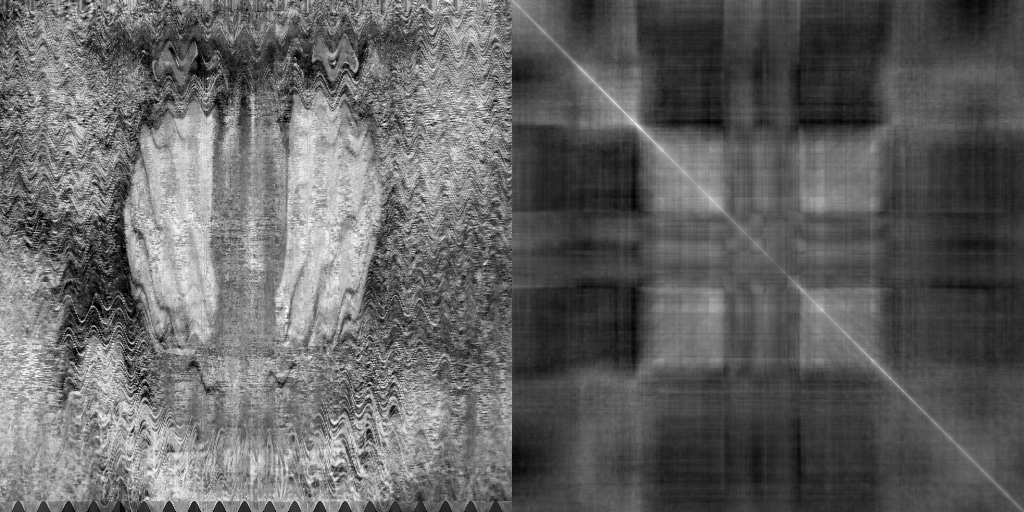

In [47]:
Gray.(hcat(m_im0_warped, value3(m_im0_warped)))

In [48]:
delta = m_im0_warped - m_im0_warped_copy

512×512 Matrix{Float64}:
 -0.120619    0.0613736   0.0219144  -0.0441855   …  -0.00672031  -0.139614
 -0.111689    0.110563    0.0847127   0.00624984     -0.0976978   -0.124461
 -0.138111    0.0817209   0.041751   -0.112743       -0.092217    -0.127337
 -0.138309    0.0720589   0.0283065  -0.0733081      -0.113357    -0.153526
 -0.147355   -0.0802411   0.0348705  -0.0140498      -0.108047    -0.13645
 -0.0375251  -0.0439096   0.0949456  -0.0858028   …  -0.0100295   -0.0967891
 -0.0783137  -0.102107    0.12023     0.0920149      -0.100469    -0.139013
  0.0538292  -0.0617462   0.159481    0.156776       -0.13678     -0.13203
  0.126048   -0.105802    0.124351    0.0923569      -0.105246    -0.0642632
  0.106695   -0.176648    0.0038251  -0.0943211       0.0119743    0.199317
  0.121068    0.0522316  -0.0694699   0.154612    …  -0.100902     0.164042
  0.15793     0.146577   -0.171862    0.0532432       0.104383    -0.044254
  0.0976438   0.0246013  -0.171135    0.0533961       0.184168 

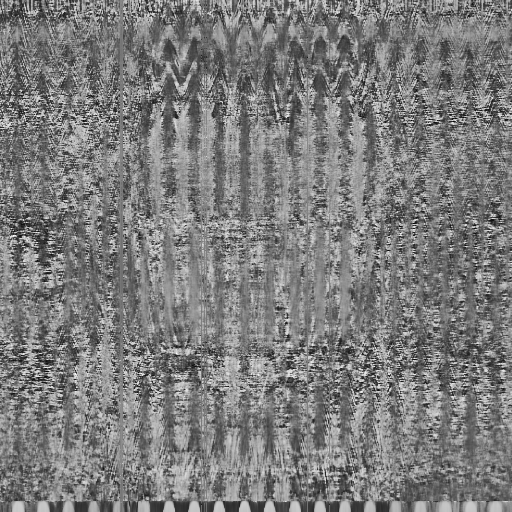

In [49]:
Gray.(normalize_image(delta))

In [50]:
using ImageCore

In [51]:
function gray_copy(color_image)
    result = deepcopy(color_image)
    result .= 0.5
end

gray_copy (generic function with 1 method)

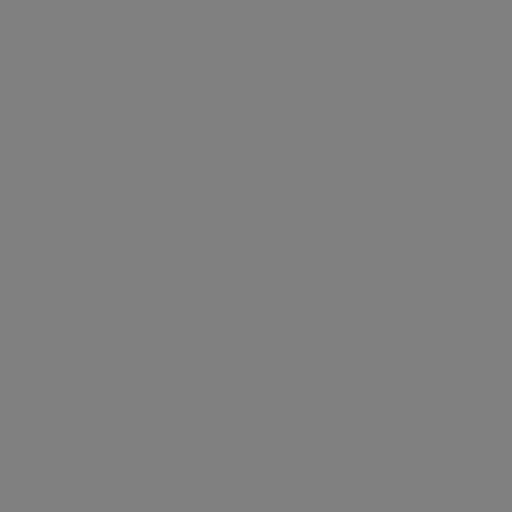

In [52]:
new_gray = gray_copy(img)

In [53]:
# requires: using ImageCore
function add_to_channels_3_1(color_image, gray_or_matrix)
    channelview(color_image)[3,:,:] += gray_or_matrix
    channelview(color_image)[1,:,:] += gray_or_matrix
    color_image
end

add_to_channels_3_1 (generic function with 1 method)

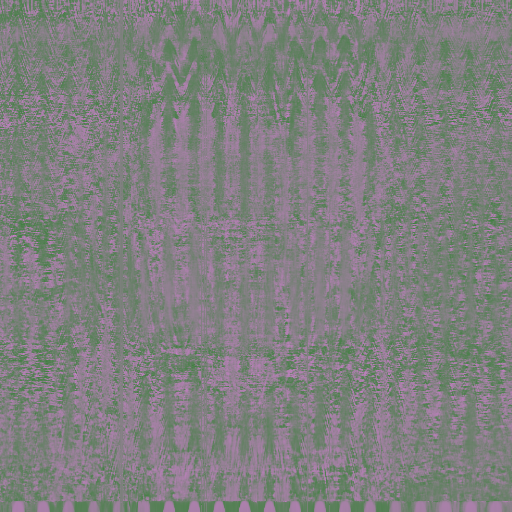

In [54]:
add_to_channels_3_1(new_gray, delta)

In [55]:
function monochrome_copy(color_image)
    result = deepcopy(color_image)
    gray_layer = Gray.(color_image)
    channelview(result)[1,:,:] = gray_layer
    channelview(result)[2,:,:] = gray_layer
    channelview(result)[3,:,:] = gray_layer
    result
end

monochrome_copy (generic function with 1 method)

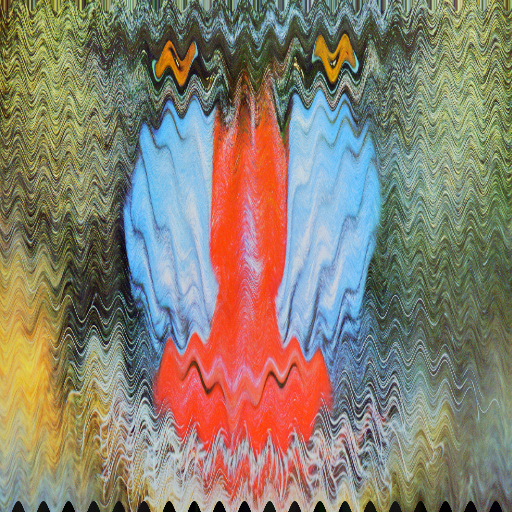

In [57]:
img_warped = apply_warp(warp3, 1*img, pars)

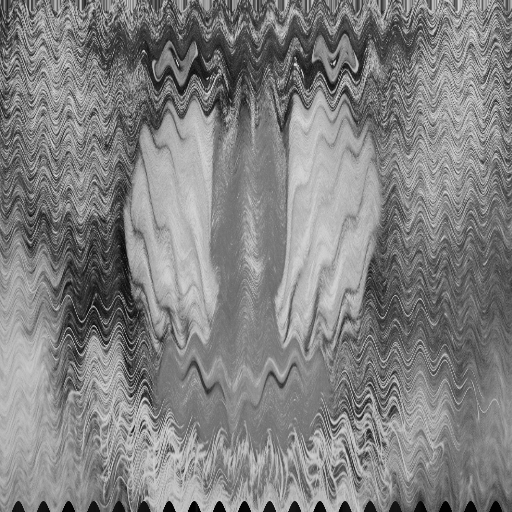

In [58]:
i_w_mono = monochrome_copy(img_warped)

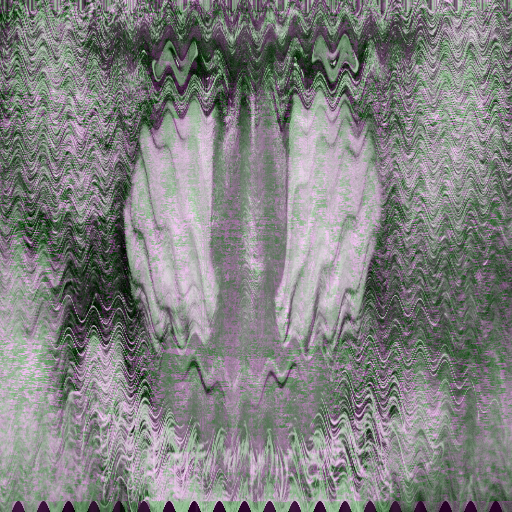

In [59]:
add_to_channels_3_1(i_w_mono, delta)

In [60]:
####################

### OK, this was somewhat similar to what we did before

### Now, let's try something different - include warp3 application into the loss

loss_new(x, y) = norm(value3(apply_warp(warp3, x, pars)) - y)

loss_new (generic function with 1 method)

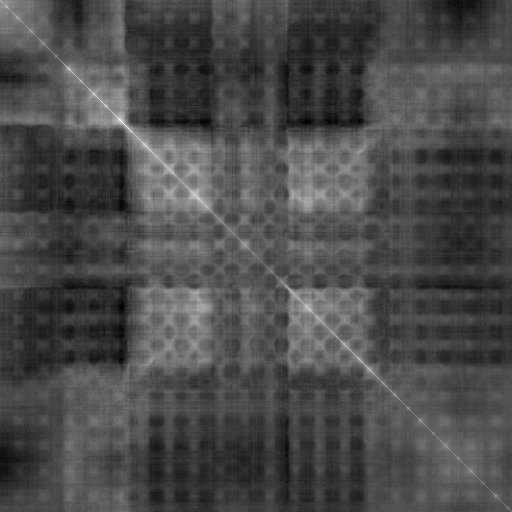

In [62]:
Gray.(value3(apply_warp(warp3, m_im0, pars)))

In [63]:
loss_new(m_im0, p_m_im0_norm)

20.39865222030749

In [64]:
opt2 = ADAM()

ADAM(0.001, (0.9, 0.999), IdDict{Any, Any}())

In [65]:
matrix_sequence = []

Any[]

In [66]:
m_im0_copy = deepcopy(m_im0)

512×512 Matrix{Float32}:
 0.568627   0.219608   0.192157   0.34902   …  0.443137  0.6        0.694118
 0.454902   0.396078   0.156863   0.262745     0.509804  0.584314   0.490196
 0.301961   0.447059   0.180392   0.180392     0.392157  0.345098   0.317647
 0.278431   0.533333   0.372549   0.188235     0.286275  0.294118   0.27451
 0.341176   0.478431   0.517647   0.196078     0.231373  0.313726   0.337255
 0.321569   0.298039   0.623529   0.239216  …  0.333333  0.596078   0.713726
 0.168627   0.2        0.52549    0.509804     0.72549   0.776471   0.643137
 0.129412   0.2        0.435294   0.6          0.631373  0.470588   0.541176
 0.223529   0.188235   0.219608   0.458824     0.529412  0.611765   0.478431
 0.14902    0.12549    0.188235   0.25098      0.254902  0.317647   0.533333
 0.129412   0.168627   0.223529   0.145098  …  0.254902  0.286275   0.266667
 0.129412   0.184314   0.305882   0.141176     0.34902   0.290196   0.294118
 0.141176   0.262745   0.352941   0.254902     0.301

In [ ]:
steps!(m_im0, p_m_im0_warped_norm, loss_new, opt2, matrix_sequence, 1)

In [ ]:
# the line above is taking forever (did we give Flux something too difficult again?)

# We'll probably need to investigate this on some smaller size matrix, like we at some earlier runs